# Customized Drug Classification Project (Original + Enhancements)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler, label_binarize
import shap
import joblib

In [2]:
data = pd.read_csv("/kaggle/input/introds/Drug.csv")
print("\nDataset shape:", data.shape)
data.head()


Dataset shape: (200, 7)


,Age,Sex,BP,Cholesterol,Na,K,Drug
0,23,F,HIGH,HIGH,0.792535,0.031258,drugY
1,47,M,LOW,HIGH,0.739309,0.056468,drugC
2,47,M,LOW,HIGH,0.697269,0.068944,drugC
3,28,F,NORMAL,HIGH,0.563682,0.072289,drugX
4,61,F,LOW,HIGH,0.559294,0.030998,drugY


In [3]:
data.isnull().sum()

Age            0
Sex            0
BP             0
Cholesterol    0
Na             0
K              0
Drug           0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na           200 non-null    float64
 5   K            200 non-null    float64
 6   Drug         200 non-null    object 
dtypes: float64(2), int64(1), object(4)
memory usage: 11.1+ KB
None
              Age          Na           K
count  200.000000  200.000000  200.000000
mean    44.315000    0.697095    0.050174
std     16.544315    0.118907    0.017611
min     15.000000    0.500169    0.020022
25%     31.000000    0.583887    0.035054
50%     45.000000    0.721853    0.049663
75%     58.000000    0.801494    0.066000
max     74.000000    0.896056    0.079788


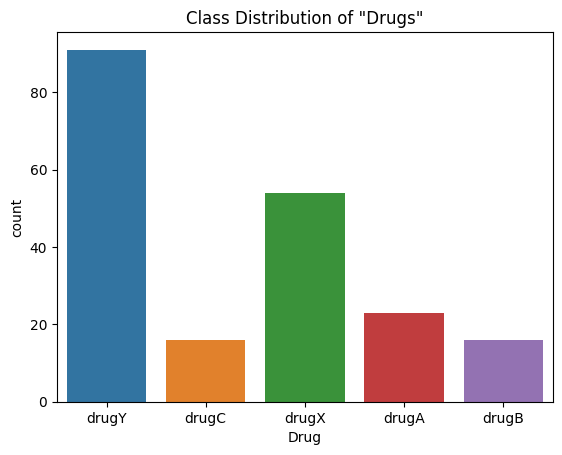

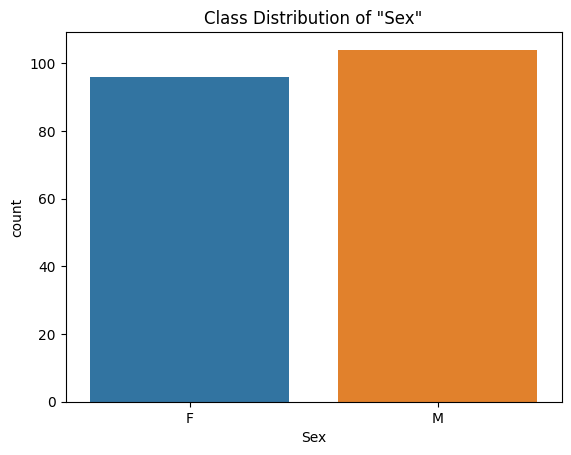

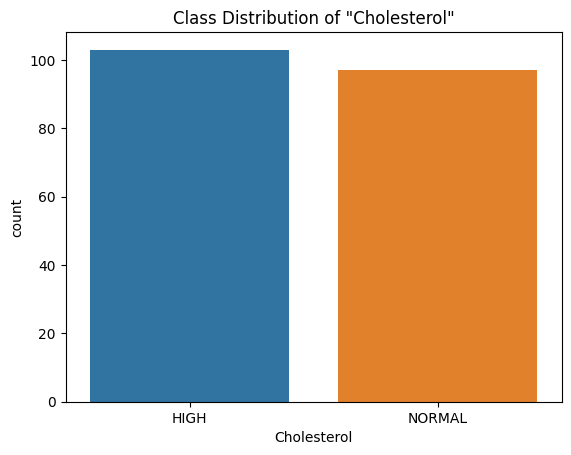

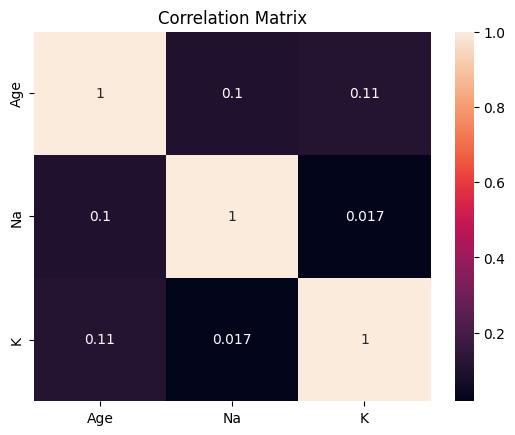

In [4]:
print(data.info())
print(data.describe())

sns.countplot(x='Drug', data=data)
plt.title('Class Distribution of "Drugs"')
plt.show()

sns.countplot(x='Sex', data=data)
plt.title('Class Distribution of "Sex"')
plt.show()

sns.countplot(x='Cholesterol', data=data)
plt.title('Class Distribution of "Cholesterol"')
plt.show()

sns.heatmap(data.corr(numeric_only=True), annot=True)
plt.title('Correlation Matrix')
plt.show()

In [5]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

X = data.drop("Drug", axis=1)
y = data["Drug"]

numerical_features = ['Age', 'Na', 'K']
categorical_features = ['Sex', 'BP', 'Cholesterol']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scale = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

X_train_scaled = scale.fit_transform(X_train)
X_test_scaled = scale.transform(X_test)

In [6]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

cv_results = {}

print("=== 5-Fold Cross-Validation Results ===\n")
for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train , cv=5, scoring='accuracy')
    mean_score = scores.mean()
    std_score = scores.std()
    cv_results[name] = mean_score
    print(f"\n{name}:")
    print(f"  Fold Accuracies: {scores}")
    print(f"  Mean Accuracy: {mean_score:.4f}")
    print(f"  Std Deviation: {std_score:.4f}\n")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print(f"Confusion Matrix for {model}:")
    print(confusion_matrix(y_test, y_pred))
    
# Select best model based on mean CV accuracy
best_model_name = max(cv_results, key=cv_results.get)
best_model = models[best_model_name]

print(f"\n✅ Best Model: {best_model_name} with Mean CV Accuracy = {cv_results[best_model_name]:.4f}")

=== 5-Fold Cross-Validation Results ===


Logistic Regression:
  Fold Accuracies: [0.90625 0.9375  0.90625 0.96875 0.875  ]
  Mean Accuracy: 0.9187
  Std Deviation: 0.0319

Confusion Matrix for LogisticRegression(max_iter=200):
[[ 6  0  0  0  0]
 [ 0  3  0  0  0]
 [ 0  0  4  0  1]
 [ 0  0  0 11  0]
 [ 0  0  0  0 15]]

K-Nearest Neighbors:
  Fold Accuracies: [0.875   0.8125  0.71875 0.90625 0.8125 ]
  Mean Accuracy: 0.8250
  Std Deviation: 0.0643

Confusion Matrix for KNeighborsClassifier():
[[ 6  0  0  0  0]
 [ 0  3  0  0  0]
 [ 1  0  2  1  1]
 [ 1  0  0  9  1]
 [ 0  0  0  0 15]]

Decision Tree:
  Fold Accuracies: [0.84375 1.      0.90625 0.875   0.875  ]
  Mean Accuracy: 0.9000
  Std Deviation: 0.0538

Confusion Matrix for DecisionTreeClassifier(random_state=42):
[[ 5  0  0  0  1]
 [ 0  3  0  0  0]
 [ 0  0  4  0  1]
 [ 0  0  0 10  1]
 [ 1  0  0  0 14]]

Random Forest:
  Fold Accuracies: [0.875   0.96875 0.90625 0.84375 0.90625]
  Mean Accuracy: 0.9000
  Std Deviation: 0.0415

Confusio

                 Model  Accuracy
0  Logistic Regression   0.91875
1  K-Nearest Neighbors   0.82500
2        Decision Tree   0.90000
3        Random Forest   0.90000


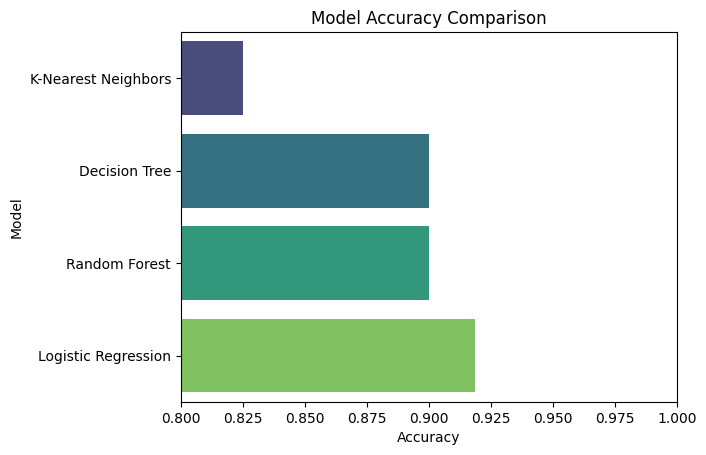

In [7]:
cv_results_df = pd.DataFrame(list(cv_results.items()), columns=['Model', 'Accuracy'])
print(cv_results_df)
sns.barplot(x="Accuracy", y="Model", data=cv_results_df.sort_values("Accuracy", ascending=True), palette="viridis")
plt.title("Model Accuracy Comparison")
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.xlim(0.8, 1.0)
plt.show()


In [8]:
bm = best_model
bm.fit(X_train_scaled, y_train)
y_pred = bm.predict(X_test_scaled)
acc = accuracy_score(y_test,y_pred)
print(f"\n{bm} Accuracy by Test-Train split: {acc:.4f}")
print(f"Confusion Matrix for {bm}:")
print(confusion_matrix(y_test, y_pred))
print(f"Classification Report for {bm}:")
print(classification_report(y_test, y_pred))



LogisticRegression(max_iter=200) Accuracy by Test-Train split: 0.9750
Confusion Matrix for LogisticRegression(max_iter=200):
[[ 6  0  0  0  0]
 [ 0  3  0  0  0]
 [ 0  0  4  0  1]
 [ 0  0  0 11  0]
 [ 0  0  0  0 15]]
Classification Report for LogisticRegression(max_iter=200):
              precision    recall  f1-score   support

       drugA       1.00      1.00      1.00         6
       drugB       1.00      1.00      1.00         3
       drugC       1.00      0.80      0.89         5
       drugX       1.00      1.00      1.00        11
       drugY       0.94      1.00      0.97        15

    accuracy                           0.97        40
   macro avg       0.99      0.96      0.97        40
weighted avg       0.98      0.97      0.97        40



In [9]:
feature_names = scale.get_feature_names_out()
importance = best_model.coef_[0]  # array of coefficients for each feature

# Create a DataFrame for easier interpretation
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': importance,
    'Abs_Coefficient': np.abs(importance)
}).sort_values(by='Abs_Coefficient', ascending=False)

print(importance_df)

                   Feature  Coefficient  Abs_Coefficient
5             cat__BP_HIGH     1.683538         1.683538
2                   num__K     0.904252         0.904252
0                 num__Age    -0.900149         0.900149
6              cat__BP_LOW    -0.862934         0.862934
7           cat__BP_NORMAL    -0.820187         0.820187
1                  num__Na    -0.667092         0.667092
4               cat__Sex_M     0.093448         0.093448
3               cat__Sex_F    -0.093031         0.093031
8    cat__Cholesterol_HIGH     0.055663         0.055663
9  cat__Cholesterol_NORMAL    -0.055245         0.055245


In [10]:
classes = sorted(y_train.unique())
y_test_bin = label_binarize(y_test, classes=classes)
y_score_bm = best_model.predict_proba(X_test_scaled)
roc_auc_macro = roc_auc_score(y_test_bin, y_score_bm, average='macro', multi_class='ovr')
print(f"\n Best Model {best_model_name} ROC-AUC (macro): {roc_auc_macro}")


 Best Model Logistic Regression ROC-AUC (macro): 1.0


The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


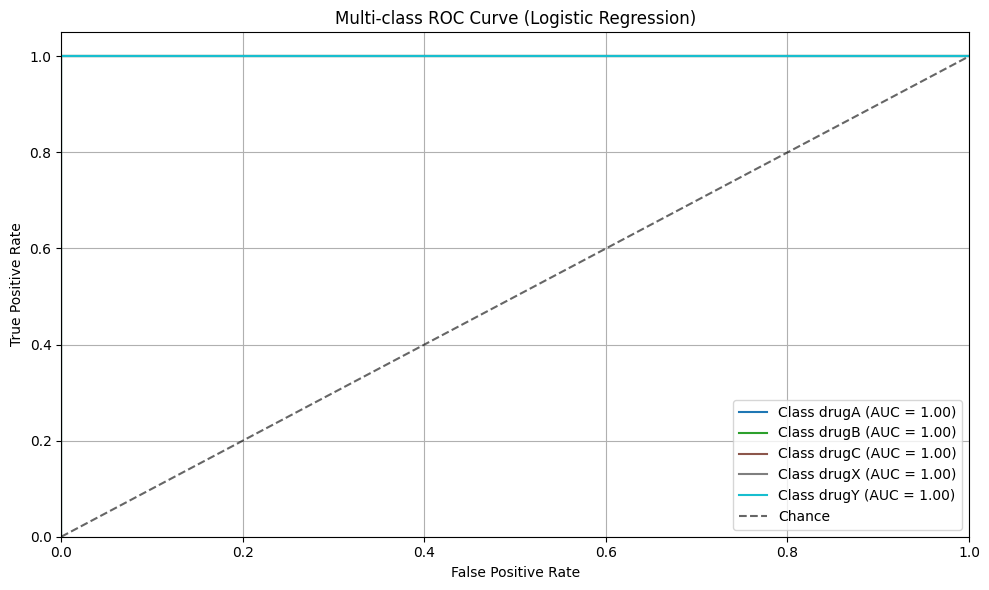

In [11]:
from sklearn.metrics import roc_curve, auc
# Number of classes
n_classes = len(classes)

# Plot setup
plt.figure(figsize=(10, 6))
colors = plt.cm.get_cmap('tab10', n_classes)

# Compute and plot ROC curve for each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score_bm[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {classes[i]} (AUC = {roc_auc:.2f})", color=colors(i))

#Plot chance line
plt.plot([0, 1], [0, 1], 'k--', label='Chance', alpha=0.6)

# Plot settings
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve (Logistic Regression)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

shap_values shape: (40, 10, 5)
shap_values[0] shape: (10, 5)
X_test_df shape: (40, 10)
X_test_df columns: ['Age', 'Na', 'K', 'Sex_F', 'Sex_M', 'BP_HIGH', 'BP_LOW', 'BP_NORMAL', 'Cholesterol_HIGH', 'Cholesterol_NORMAL']

Summary Plot for Class 0


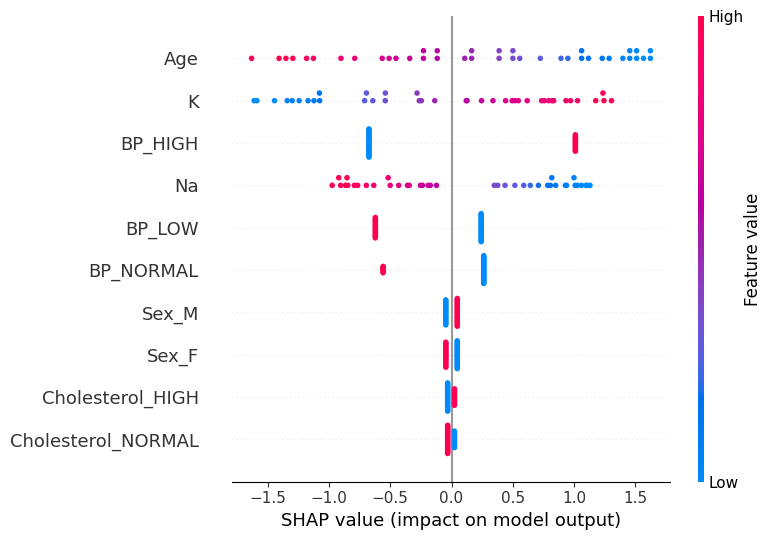


Summary Plot for Class 1


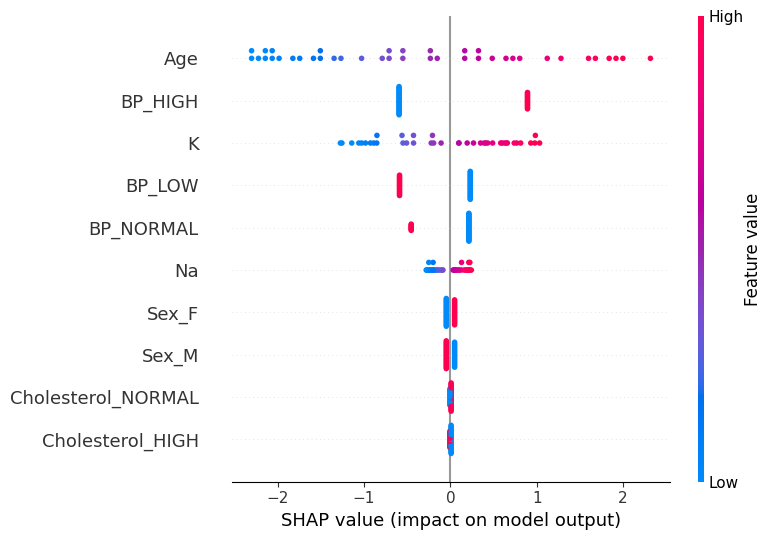


Summary Plot for Class 2


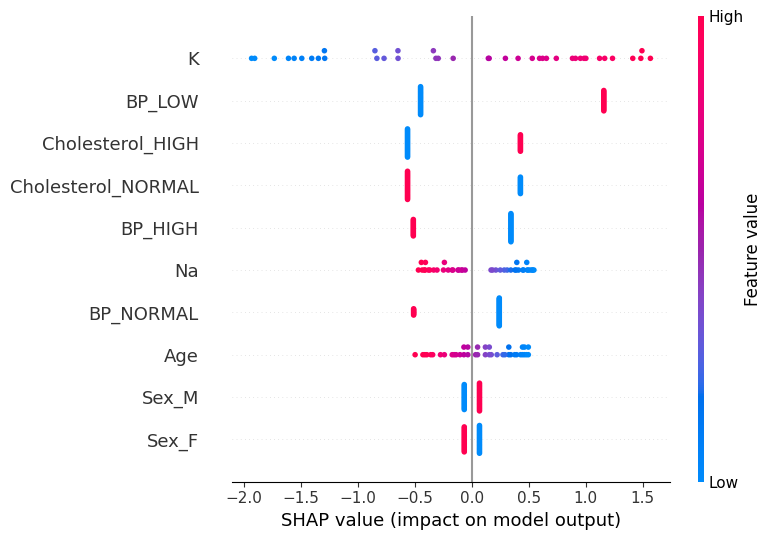


Summary Plot for Class 3


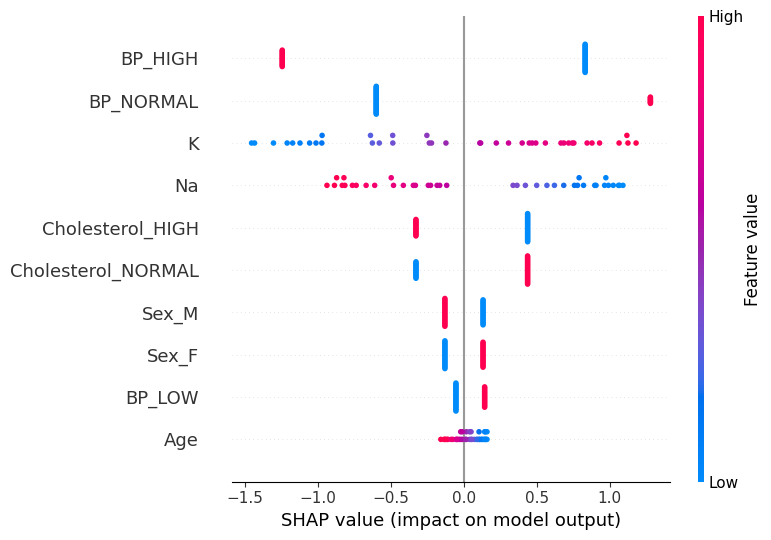


Summary Plot for Class 4


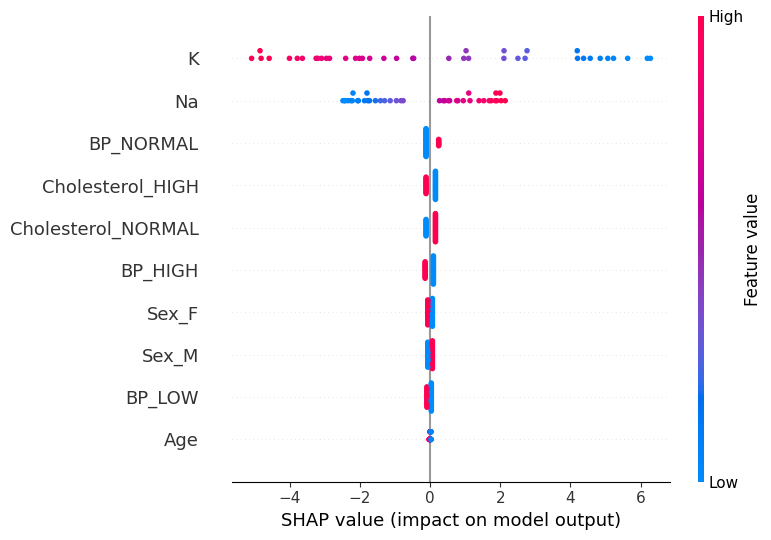


Waterfall plot for first sample, class 0


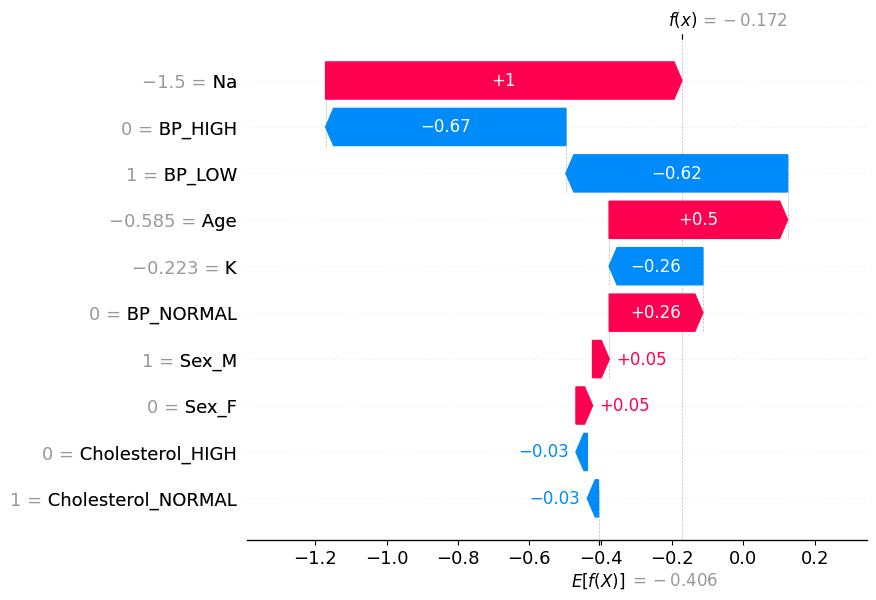

In [12]:
# Step 1: Get encoded column names (assumes OneHotEncoder with get_feature_names_out)
encoded_feature_names = scale.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numerical_features, encoded_feature_names])

# Step 2: Wrap X_test_scaled into a DataFrame with correct columns and index
X_test_df = pd.DataFrame(X_test_scaled, columns=all_feature_names, index=X_test.index)

# Step 3: Create SHAP Explainer
explainer = shap.Explainer(best_model, X_train_scaled, feature_names=all_feature_names)

# Step 4: Compute SHAP values for X_test
shap_values = explainer(X_test_scaled)

# Sanity check
print("shap_values shape:", shap_values.values.shape)  # Should be (n_samples, n_features, n_classes)
print("shap_values[0] shape:", shap_values[0].shape)   # (n_features, n_classes)
print("X_test_df shape:", X_test_df.shape)
print("X_test_df columns:", X_test_df.columns.tolist())

# Step 5: Class-wise SHAP Summary Plots
n_classes = shap_values.values.shape[2]  # shape = (samples, features, classes)
for i in range(n_classes):
    print(f"\nSummary Plot for Class {i}")
    shap_class_i = shap_values.values[:, :, i]  # shape: (n_samples, n_features)
    shap.summary_plot(shap_class_i, X_test_df, feature_names=all_feature_names)

# #Step 6: Beeswarm plots using Explanation object
# for i in range(n_classes):
#     class_vals = shap_values.values[:, :, i]       # (samples, features)
#     class_base = shap_values.base_values[:, i]     # (samples,)
    
#     class_expl = shap.Explanation(
#         values=class_vals,
#         base_values=class_base,
#         data=X_test_df.values,
#         feature_names=all_feature_names
#     )
    
#     print(f"\nSHAP Beeswarm Plot for Class {i}")
#     shap.plots.beeswarm(class_expl)

#Step 7: Local explanation (waterfall) for first sample, class 0
print("\nWaterfall plot for first sample, class 0")
sample_0 = shap.Explanation(
    values=shap_values.values[0, :, 0],               # (features,)
    base_values=shap_values.base_values[0, 0],        # scalar
    data=X_test_df.iloc[0].values,
    feature_names=all_feature_names
)
shap.plots.waterfall(sample_0)


In [13]:
joblib.dump(bm, 'drug_classifier_rf.pkl')

['drug_classifier_rf.pkl']